In [1]:
from concurrent.futures import ThreadPoolExecutor
import sys
import argparse
import torch, os, random, gym, time
import numpy as np

from torch import nn
from torch.autograd import Variable
from wrapper.gym_wrapper import make_atari, wrap_deepmind
from matplotlib import pyplot as plt, gridspec
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

In [2]:
lambda_reg = 0.01
n_aggregates = 20
min_val = -25
max_val = 25
agg_values = np.linspace(min_val, max_val, n_aggregates)

use_cuda = True
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

mean_pixel_image = Variable(FloatTensor(np.zeros((210, 160, 12))), requires_grad=False)

class QNetwork(nn.Module):
    def __init__(self, input_shape, output_len, hidden_dim):
        super(QNetwork, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Linear(conv_out_size, hidden_dim)

        self.deconv_fc = nn.Linear(hidden_dim, conv_out_size)

        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, output_padding=(1,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=8, stride=4, output_padding=(2, 0))
        )

        # self.query_embed = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.key_matrix = nn.Parameter(torch.randn(output_len, n_aggregates, hidden_dim))
        self.register_buffer('agg_values', Variable(FloatTensor(agg_values).view(n_aggregates, 1)))

        self.init_weights()

    def forward(self, x):
        x = x.float() - mean_pixel_image
        x = x / 255.0
        x = x.permute(0, 3, 1, 2)   # NCHW format

        fx= self.conv(x).view(x.size()[0], -1)

        x_embed = self.fc(fx)

        # q = torch.mm(x_embed, torch.t(self.query_embed))
        q = x_embed

        att_keys = torch.matmul(self.key_matrix, torch.t(q))
        soft_keys = nn.Softmax(dim=1)(att_keys)

        att_values = soft_keys * self.agg_values
        att_values = att_values.sum(dim=1)

        # att_log_px = soft_keys.log()
        # att_entropy = -soft_keys * att_log_px
        # att_loss = torch.sum(att_entropy)

        reconstructed_img = self.deconv(self.deconv_fc(x_embed).view(x.size()[0], 64, 22, 16))
        # reconstruction_loss = (reconstructed_img - x).pow(2).sum()

        return torch.t(att_values), soft_keys, reconstructed_img

    def get_embed(self, x):
        x = x.float() - mean_pixel_image
        x = x / 255.0
        x = x.permute(0, 3, 1, 2)  # NCHW format

        fx = self.conv(x).view(x.size()[0], -1)

        x_embed = self.fc(fx)

        return x_embed

    def _get_conv_out(self, shape):
        o = self.conv(Variable(torch.zeros(1, *shape)))
        return int(np.prod(o.size()))

    def reconstruct_key(self, key_embed):
        return self.deconv(self.deconv_fc(key_embed).view(key_embed.size()[0], 64, 22, 16))

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
                nn.init.xavier_uniform(layer.weight.data)
                nn.init.constant(layer.bias.data, 0.0)

            if isinstance(layer, nn.Linear):
                nn.init.normal(layer.weight.data, 0, 0.1)

            if isinstance(layer, nn.Parameter):
                nn.init.normal(layer.data, 0, 0.1)

    def save_model_weights(self, suffix):
        # Helper function to save your model / weights.
        torch.save(self.state_dict(), suffix)

    def load_model_weights(self, model_file, strict=True):
        model_dict = torch.load(model_file)
        model_dict.pop('agg_values')
        self.load_state_dict(model_dict,strict)

In [3]:
lambda_exp=0.001

def action_selector(q_distributions):
    means = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1))
    variances = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1).pow(2))
    variances = variances - means
    std_devs = variances.sqrt()

    optimistic_returns = means + lambda_exp * std_devs
    _, action = torch.max(optimistic_returns, dim=0)
    action = int(action)

    return action

def process_img(state):
    return np.array(state)

In [4]:
env_name = 'MsPacmanNoFrameskip-v4'
hidden_dim = 256
model_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/ucb-color-25-25/best-models/model.5268.927.tar'
mean_image_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/ucb-color-25-25/mean_pixel_image.npy'


env = make_atari(env_name)
env = wrap_deepmind(env, frame_stack=True, scale=False, clip_rewards=False, episode_life=False)
n_action = env.action_space.n

meanings = env.unwrapped.get_action_meanings()

state = env.reset()
state_p = np.array(state).reshape(12, 210, 160).astype(np.float32) / 255.0

net = QNetwork(state_p.shape, n_action, hidden_dim)
if use_cuda:
    net = net.cuda()

net.load_model_weights(model_file, False)
mean_pixel_image = Variable(FloatTensor(np.load(mean_image_file)), requires_grad=False)

print('Loaded saved files')

Loaded saved files


In [7]:
total_reward = 0
done = False
episode_length = 011
trajectory = []

while not done:
    trajectory.append(state)
    q_values, soft_keys, re_img = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
    soft_keys = soft_keys[:, :, 0]
    act = action_selector(soft_keys)
    next_state, reward, done, _ = env.step(act)
    
    f = plt.figure()
    gs = gridspec.GridSpec(nrows=1, ncols=1)
    a0 = f.add_subplot(gs[0, 0])
    a0.imshow(state[:, :, 9:])
    a0.axis('off')
    f.savefig('/tmp/trajectory/%d.png' % episode_length)
    plt.close()
    
    state = next_state
    total_reward += reward
    episode_length += 1
    
print('Total rewards: %.4f' % total_reward)

Total rewards: 5210.0000


In [101]:
np.save('trajectory.np', trajectory)

/home/raghu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


8


/home/raghu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/raghu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


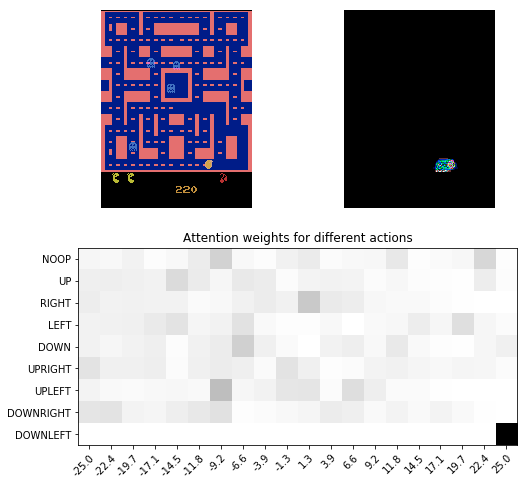

6


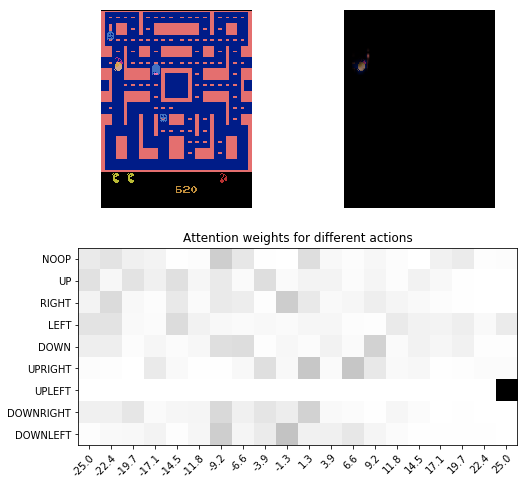

5


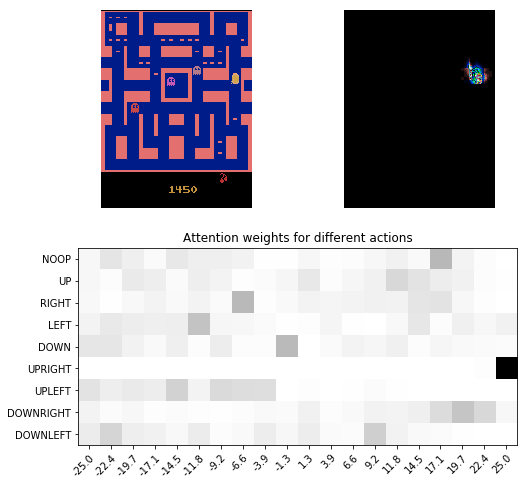

1


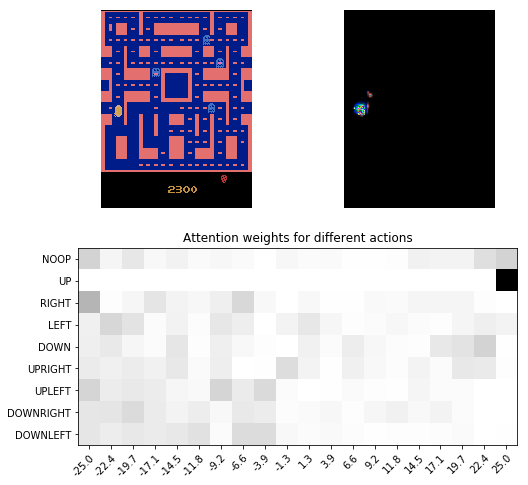

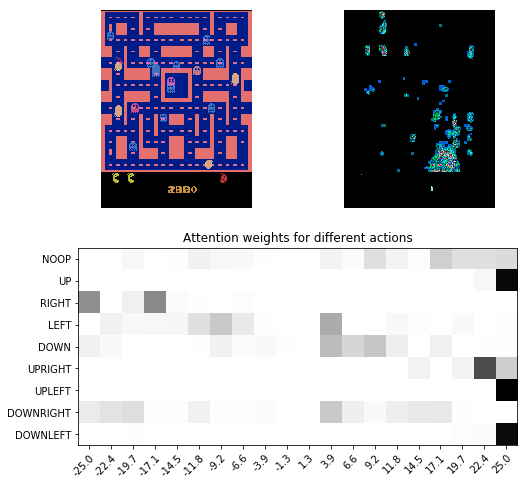

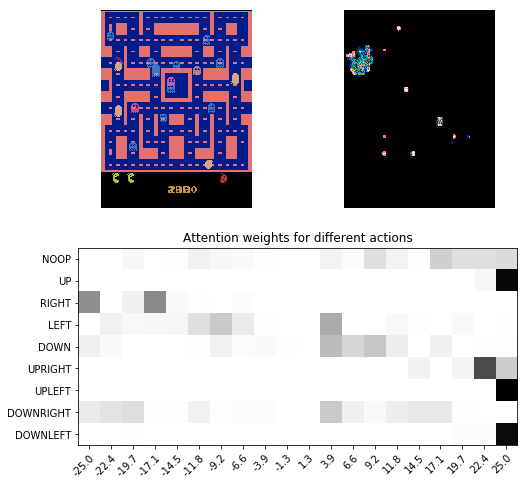

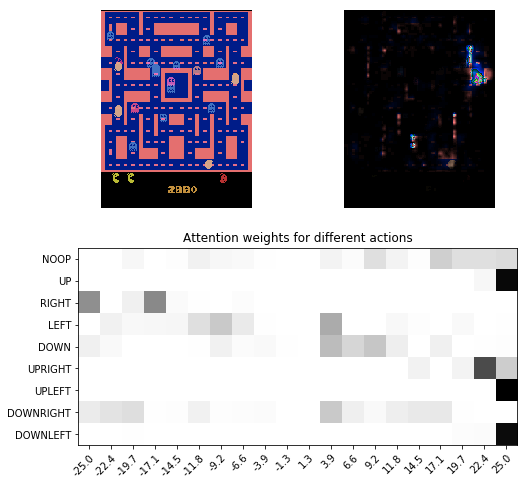

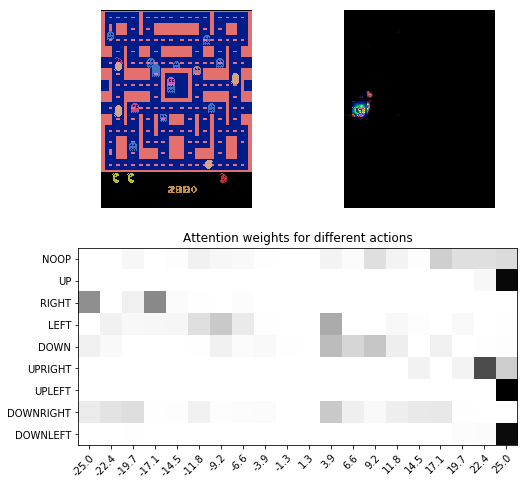

In [43]:
def get_score(model, img, act):
    q_values, _, _ = model(Variable(FloatTensor(img[None]), volatile=True))
    return q_values[0][act].cpu().data.numpy()[0]


def get_mask(center, size, r):
    y, x = np.ogrid[-center[0]:size[0] - center[0], -center[1]:size[1] - center[1]]
    keep = x * x + y * y <= 1
    mask = np.zeros(size);
    mask[keep] = 1
    mask = gaussian_filter(mask, sigma=r)
    return mask / mask.max()


def plot_saliency(model, img, act):
    r = 3
    d = 3

    L = get_score(model, img, act)

    scores = np.zeros((int(210 / d) + 1, int(160 / d) + 1))  # saliency scores S(t,i,j)
    for i in range(0, 210, d):
        for j in range(0, 160, d):
            mask = get_mask(center=[i, j], size=[210, 160], r=r)

            mask = np.repeat(mask[:, :, np.newaxis], 12, axis=2)
            new_img = img * (1 - mask) + gaussian_filter(img, sigma=5) * mask
            new_img = np.clip(new_img, 0, 255.0).astype(np.uint8)

            l = get_score(model, new_img, act)
            scores[int(i / d), int(j / d)] = (0.5 * (L - l) ** 2)
    pmax = scores.max()
    scores = imresize(scores, size=[210, 160], interp='bilinear').astype(np.float32)
    scores = pmax * scores / scores.max()

    scores = np.repeat(scores[:, :, np.newaxis], 3, axis=2)

    saliency = scores * img[:, :, 9:]
    saliency = saliency.astype(np.uint8)

    return saliency    


def draw_plot(state_np, saliency_on=True, saliency_act=None):
    f = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(nrows=2, ncols=2)

    a0 = f.add_subplot(gs[0, 0])
    a1 = f.add_subplot(gs[1, :])    
    
    a0 = f.add_subplot(gs[0, 0])
    a0.imshow(state_np[:, :, 9:])
    a0.axis('off')
    
    q_values, soft_keys, re_img = net(Variable(FloatTensor(state_np[None]), volatile=True))
    prob_dist = 1.0 - soft_keys.cpu().data.numpy().reshape(n_action, 20)
    actions = np.arange(n_action)
    aggs = agg_values

    im = a1.imshow(prob_dist, cmap='gray', interpolation='nearest')

    a1.set_xticks(np.arange(len(aggs)))
    a1.set_yticks(np.arange(len(actions)))
    a1.set_xticklabels(['%.1f' % x for x in aggs])
    a1.set_yticklabels([meanings[x] % x for x in actions])

    plt.setp(a1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    a1.set_title("Attention weights for different actions")    
    
    if saliency_on:
        a2 = f.add_subplot(gs[0, 1])
        soft_keys = soft_keys[:, :, 0]
        if saliency_act is None:
            saliency_act = action_selector(soft_keys)
            print(saliency_act)
        saliency = plot_saliency(net, state_np, saliency_act)
        a2.imshow(saliency)
        a2.axis('off')
    
    plt.show()
    plt.close()
    

# Select specific frames
new_img = None
ids = [121, 261, 725, 1125]
# ids = [258, 259, 260, 261, 262]

for tj_id in ids:
    state_np = process_img(trajectory[tj_id])
    if new_img is None:
        new_img = state_np
    else:
        new_img = np.maximum(new_img, state_np)
    draw_plot(state_np)
    
# new_img = np.maximum(process_img(trajectory[121]), process_img(trajectory[260]))
draw_plot(new_img, True, 8)
draw_plot(new_img, True, 6)
draw_plot(new_img, True, 5)
draw_plot(new_img, True, 1)
# q_values, soft_keys, re_img = net(Variable(FloatTensor(new_img[None]), volatile=True))



In [99]:
imp_states = []
for state in trajectory:
    q_values, soft_keys, re_img = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
    soft_keys = soft_keys[:, :, 0]
    if soft_keys[1, 19].cpu().data.numpy()[0] > 0.99:
        imp_states.append(state)
print(len(imp_states))

6


(210, 160, 3)


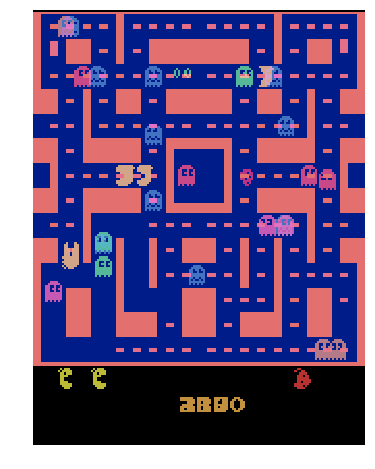

In [100]:
downleft_25 = None
for state in imp_states:
    if downleft_25 is None:
        downleft_25 = process_img(state)[:,:,:3]        
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,3:6])
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,6:9])
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,9:])
    else:
        downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,:3])
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,3:6])        
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,6:9])
#         downleft_25 = np.maximum(downleft_25, process_img(state)[:,:,9:])
        
# downleft_25 = downleft_25.astype(np.uint8)
print(downleft_25.shape)
f = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(nrows=1, ncols=1)
a0 = f.add_subplot(gs[0, 0])
a0.imshow(downleft_25)
a0.axis('off')

plt.show()
plt.close()